A. verificăm faptul ca dialectele sunt clasificabile intre ele <br>
&ensp;    0. etichetele de clasificare sunt Irish, Scottish, English <br>
&ensp;    1. iau paragrafele textele in engleza (liniile din tabel) <br>
&ensp;    2. fac shuffle per fiecare eticheta, ca sa creez exemple de clasificare care conțin un nr variat de autori si subiecte <br>
&ensp;    3. creez exemple de clasificare cu cate 500 de cuvinte fiecare, fara sa rupem propozițiile <br>
&ensp;&ensp;        3.1 trebuie sa ne asigurăm ca numărul total de exemple din fiecare clasa este ~ identic <br>
&ensp;    4. o prima clasificare tf-idf cu vocabulary=english_stop_words <br>
&ensp;&ensp;        4.1 afisam un confusion matrix <br>
&ensp;&ensp;        4.2 ca metrici de clasificare putem folosi balanced accuracy sau MCC <br>
&ensp;    5. folosim shap https://github.com/shap/shap pentru a scoate niste grafice de explainability <br>
B. repetăm pasii de la A, dar pe celelalte limbi <br>
C. 
grafic cu dimensiuni de texte increasing
crossvalidation cu std deviation

In [17]:
import pandas as pd
import json
import numpy as np
import re
from nltk import tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.neural_network import MLPClassifier

In [2]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/cricoche/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
# 0. etichetele de clasificare sunt Irish, Scottish, English
STATES = ['England','Ireland','Scotland']

In [3]:
df = pd.read_csv('../dataset/dataset_multilingual.csv') 
df = df[df['state'].isin(STATES)]

In [4]:
# Number of speeches in each dialect
for s in STATES:
    print(s + ": " + str(len(df[df['state']==s])))

England: 6053
Ireland: 2810
Scotland: 2223


In [5]:
# Average number of words per speech in dialect, total number of words from dataset
for s in STATES:
    speeches = [len(x.split(" ")) for x in df[df['state']==s]['en']]
    # print(speeches)
    print(s + ": " + str(np.mean(speeches)) + ", " + str(np.sum(speeches)))

England: 276.5560878903023, 1673994
Ireland: 271.72099644128116, 763536
Scotland: 195.60143949617634, 434822


In [6]:
434822/500

869.644

In [7]:
# Turn text to lowercase
def lowerFun(text):
    return text.lower()

# Remove punctuations
def removePunctuation(text):
    text.replace("\n","")
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for c in text:
        if c in punc:
            text = text.replace(c, "")
    return text
    
def removePunctuationList(text_list):
    for i in range(len(text_list)):
        text_list[i] = removePunctuation(text_list[i])
    return text_list

def processTexts(lang='en'):
    df[lang] = df[lang].apply(lowerFun)
    # Split the data into sentences: 
    df[lang] = df[lang].apply(tokenize.sent_tokenize) 
    df[lang] = df[lang].apply(removePunctuationList)

In [ ]:
# 2. fac shuffle per fiecare eticheta, ca sa creez exemple de clasificare care conțin un nr variat de autori si subiecte
# Avem 2223 speeches/ dialect

In [ ]:
# B. repetăm pasii de la A, dar pe celelalte limbi

In [12]:
languages = ['da', 'de', 'en', 'es', 'fr', 'it', 'nl']

for l in languages:
    processTexts(l)

eng_df = df[df['state']=='England'].sample(n=2223)
irs_df = df[df['state']=='Ireland'].sample(n=2223)
sco_df = df[df['state']=='Scotland'].sample(n=2223)

# Write preprocessed data to file

eng_df.to_csv('../dataset/eng_df_preprocessed.csv')
irs_df.to_csv('../dataset/irs_df_preprocessed.csv')
sco_df.to_csv('../dataset/sco_df_preprocessed.csv')

In [13]:
def create_classification_examples(df, example_size, lang='en'):
    # returns list of classification examples
    result = []
    current_example = ""
    for speech_list in df[lang]:
        for sentence in speech_list:
            current_example += sentence
            if len(current_example) > example_size:
                result.append(current_example)
                current_example = ""
    if current_example != "":
        result.append(current_example)
    return result

In [24]:
for example_size in range(100, 501, 50):
    for l in languages:
        eng_class = create_classification_examples(eng_df, example_size, l)
        irs_class = create_classification_examples(irs_df, example_size, l)
        sco_class = create_classification_examples(sco_df, example_size, l)
        
        label = len(eng_class) * ['eng'] + len(irs_class) * ['irs'] + len(sco_class) * ['sco']
        texts = eng_class + irs_class + sco_class
        pd.DataFrame({'text' : texts, 'label' : label}).sample(frac=1).to_csv('../dataset/CLASS_DFS_v2/' + l + '_'+ str(example_size) + '_classification_df.csv')

In [21]:
def predict(vectorizer, X_train, X_test, y_train, classifier=LogisticRegression(max_iter=1000)):
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    classifier.fit(X_train_tfidf, y_train)
    
    # Predict on the test set
    y_pred = classifier.predict(X_test_tfidf)
    return y_pred

def plot_confusion_matrix(conf_matrix, lang='en'):
    labels = ['eng', 'irs', 'sco']
    plt.figure(figsize=(4, 2))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix '+lang)
    plt.show()

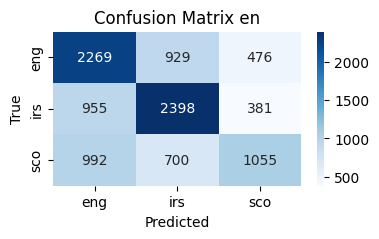

Balanced Accuracy for en - 100: 0.5479
Matthews Correlation Coefficient (MCC) for en - 100: 0.3343


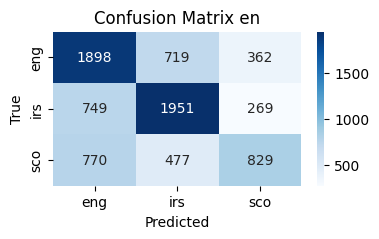

Balanced Accuracy for en - 150: 0.5645
Matthews Correlation Coefficient (MCC) for en - 150: 0.3608


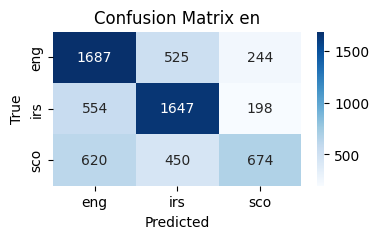

Balanced Accuracy for en - 200: 0.5866
Matthews Correlation Coefficient (MCC) for en - 200: 0.3999


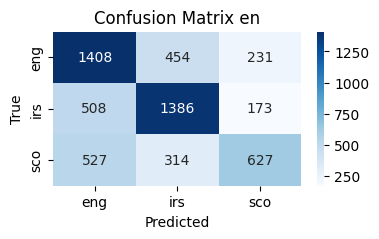

Balanced Accuracy for en - 250: 0.5901
Matthews Correlation Coefficient (MCC) for en - 250: 0.4001


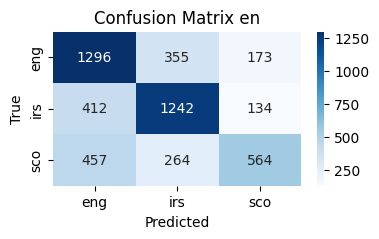

Balanced Accuracy for en - 300: 0.6147
Matthews Correlation Coefficient (MCC) for en - 300: 0.4402


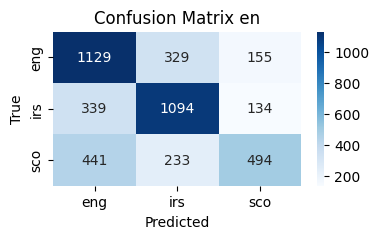

Balanced Accuracy for en - 350: 0.6070
Matthews Correlation Coefficient (MCC) for en - 350: 0.4286


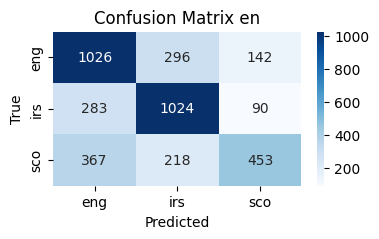

Balanced Accuracy for en - 400: 0.6234
Matthews Correlation Coefficient (MCC) for en - 400: 0.4541


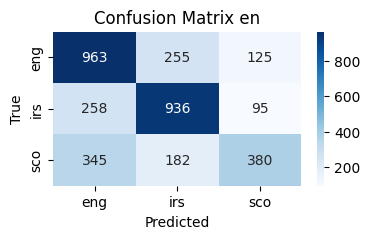

Balanced Accuracy for en - 450: 0.6207
Matthews Correlation Coefficient (MCC) for en - 450: 0.4544


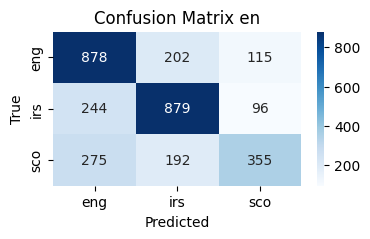

Balanced Accuracy for en - 500: 0.6292
Matthews Correlation Coefficient (MCC) for en - 500: 0.4678


In [25]:
#Comparing example size accuracy for english language
vectorizer = TfidfVectorizer()

for example_size in range(100, 501, 50):
    class_df = pd.read_csv('../dataset/CLASS_DFS_v2/en_' + str(example_size) + '_classification_df.csv')
    X_train, X_test, y_train, y_test = train_test_split(
            class_df['text'], class_df['label'], test_size=0.2, random_state=42)
    y_pred = predict(vectorizer, X_train, X_test, y_train)
    conf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(conf_matrix, 'en')
    
    b_accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy for en - {example_size}: {b_accuracy:.4f}")
    
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient (MCC) for en - {example_size}: {mcc:.4f}")

    

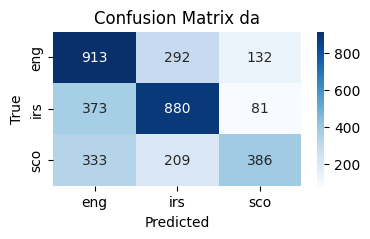

Balanced Accuracy for da: 0.5862
Matthews Correlation Coefficient (MCC) for da: 0.3955


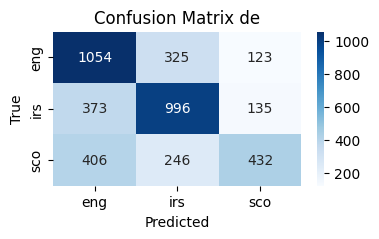

Balanced Accuracy for de: 0.5875
Matthews Correlation Coefficient (MCC) for de: 0.4001


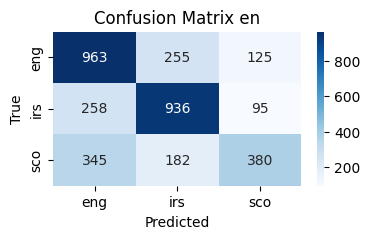

Balanced Accuracy for en: 0.6207
Matthews Correlation Coefficient (MCC) for en: 0.4544


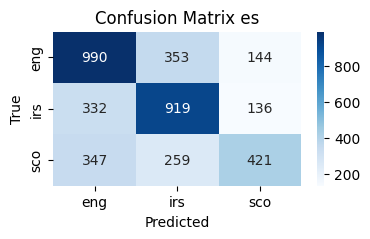

Balanced Accuracy for es: 0.5794
Matthews Correlation Coefficient (MCC) for es: 0.3837


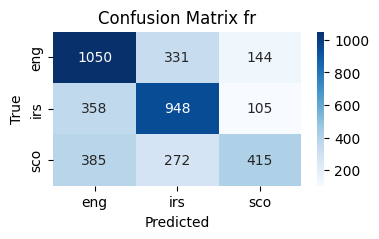

Balanced Accuracy for fr: 0.5825
Matthews Correlation Coefficient (MCC) for fr: 0.3921


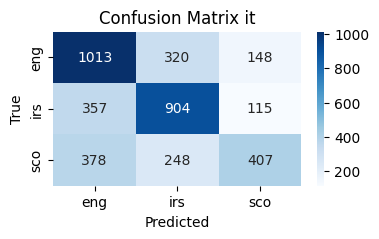

Balanced Accuracy for it: 0.5783
Matthews Correlation Coefficient (MCC) for it: 0.3843


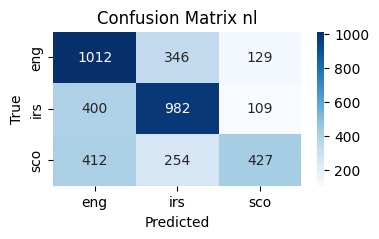

Balanced Accuracy for nl: 0.5766
Matthews Correlation Coefficient (MCC) for nl: 0.3822


In [26]:
#COmparing different languages with 450 example_size
for l in languages:
    class_df = pd.read_csv('../dataset/CLASS_DFS_v2/' + l + '_450_classification_df.csv')
    X_train, X_test, y_train, y_test = train_test_split(
            class_df['text'], class_df['label'], test_size=0.2, random_state=42)
    y_pred = predict(vectorizer, X_train, X_test, y_train)
    conf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(conf_matrix, l)
    
    b_accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy for {l}: {b_accuracy:.4f}")
    
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient (MCC) for {l}: {mcc:.4f}")

In [27]:
from sklearn.model_selection import cross_val_score

In [30]:
# Using cross validation for english and variable text size

for example_size in range(100, 501, 50):
    class_df = pd.read_csv('../dataset/CLASS_DFS_v2/en_'+ str(example_size)+'_classification_df.csv')
    clf = LogisticRegression(max_iter=1000)
    X = vectorizer.fit_transform(class_df['text'])
    y = class_df['label']
    scores = cross_val_score(clf, X, y, cv=10)
    print("For example size %d: %0.4f accuracy with a standard deviation of %0.4f" % (example_size, scores.mean(), scores.std()))

For example size 100: 0.5669 accuracy with a standard deviation of 0.0095
For example size 150: 0.5898 accuracy with a standard deviation of 0.0079
For example size 200: 0.6039 accuracy with a standard deviation of 0.0077
For example size 250: 0.6184 accuracy with a standard deviation of 0.0099
For example size 300: 0.6261 accuracy with a standard deviation of 0.0073
For example size 350: 0.6407 accuracy with a standard deviation of 0.0113
For example size 400: 0.6486 accuracy with a standard deviation of 0.0126
For example size 450: 0.6566 accuracy with a standard deviation of 0.0138
For example size 500: 0.6630 accuracy with a standard deviation of 0.0117


In [31]:
import shap

In [32]:
class_df = pd.read_csv('../dataset/CLASS_DFS_v2/en_500_classification_df.csv')

X_train, X_test, y_train, y_test = train_test_split(
            class_df['text'], class_df['label'], test_size=0.2, random_state=42)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Train Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Train MLPClassifier
mlp_model = MLPClassifier()
mlp_model.fit(X_train, y_train)

# Explain for Logistic Regression
explainer_lr = shap.LinearExplainer(lr_model, X_train, feature_dependence="independent")
shap_values_lr = explainer_lr.shap_values(X_test)

# Explain for MLPClassifier
explainer_mlp = shap.KernelExplainer(mlp_model.predict_proba, X_train[:100])  # Use a subset for KernelExplainer
shap_values_mlp = explainer_mlp.shap_values(X_test[:10])  # Use a subset to save time

# Get feature names
feature_names = vectorizer.get_feature_names_out()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


  0%|          | 0/10 [00:00<?, ?it/s]

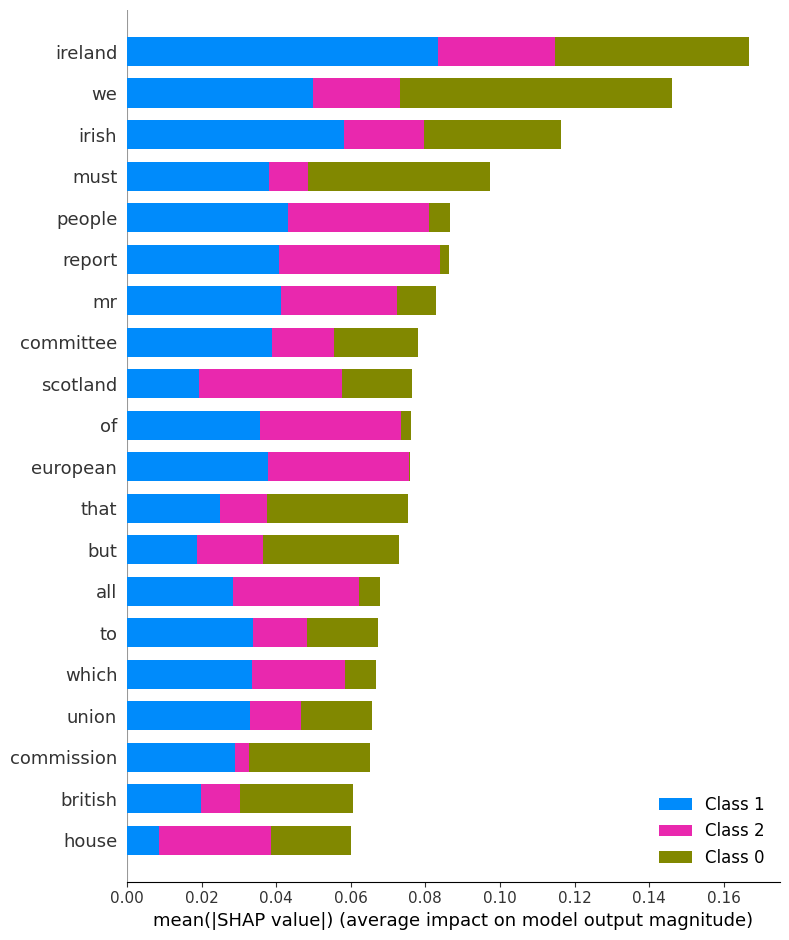

In [33]:
shap.summary_plot(shap_values_lr, X_test, feature_names=feature_names)

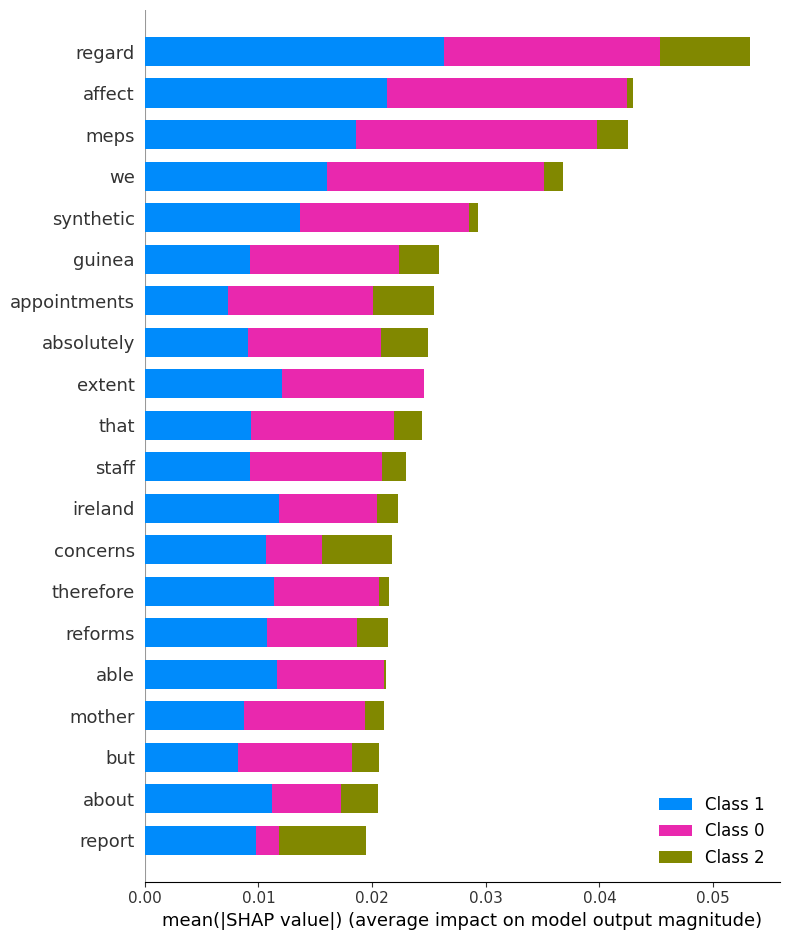

In [34]:
shap.summary_plot(shap_values_mlp, X_test[:10], feature_names=feature_names)


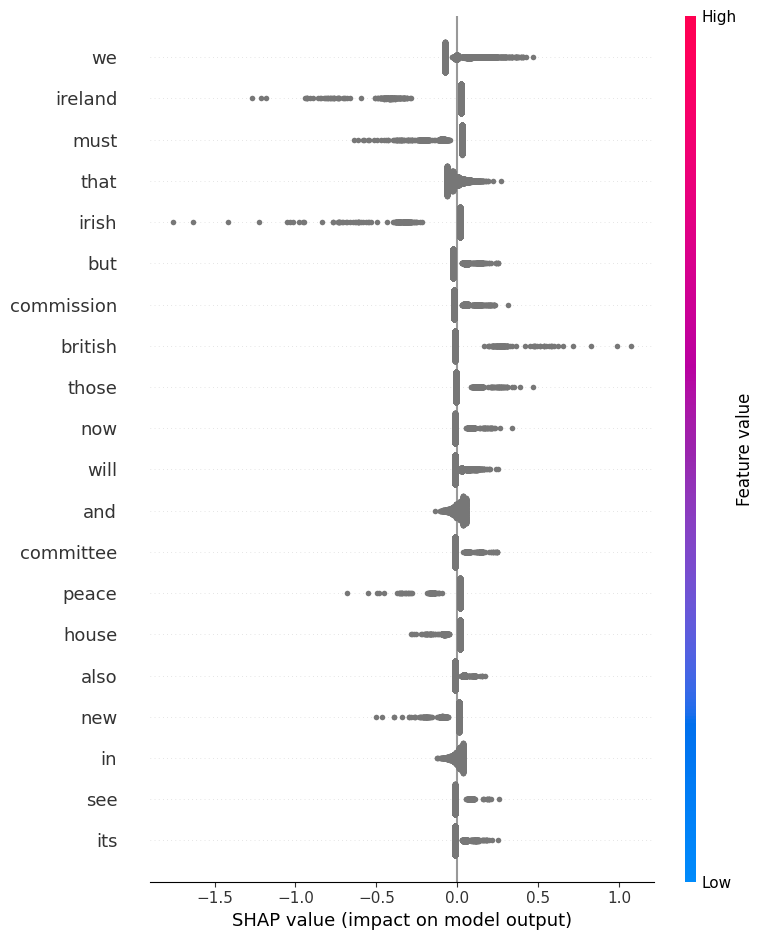

In [37]:
shap.summary_plot(shap_values_lr[0], X_test, feature_names=feature_names)

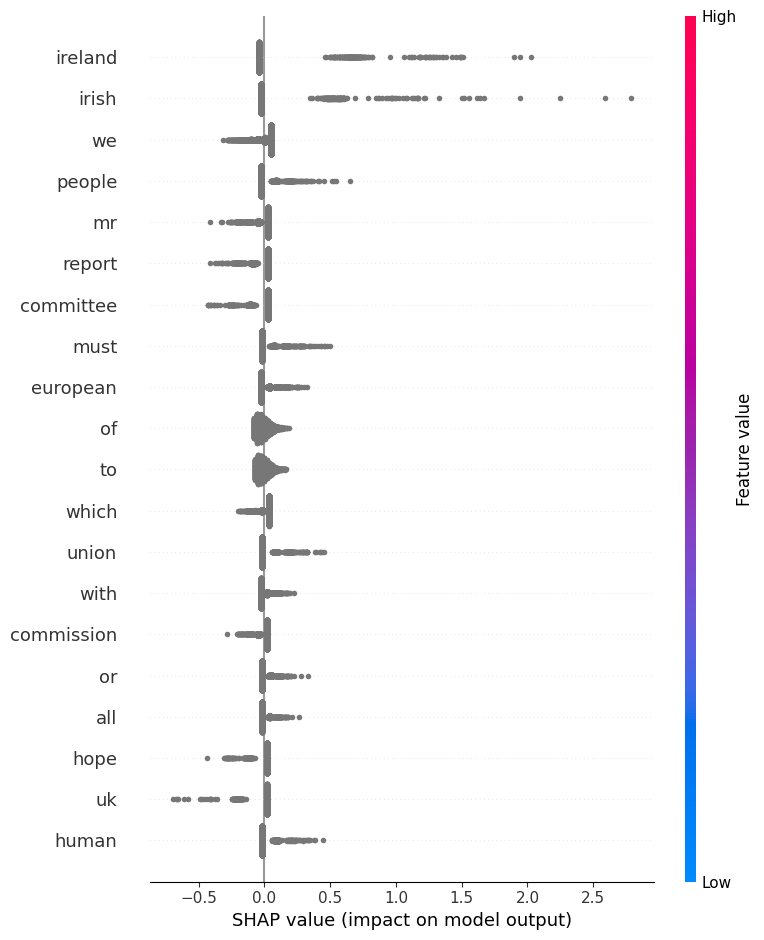

In [38]:
shap.summary_plot(shap_values_lr[1], X_test, feature_names=feature_names)

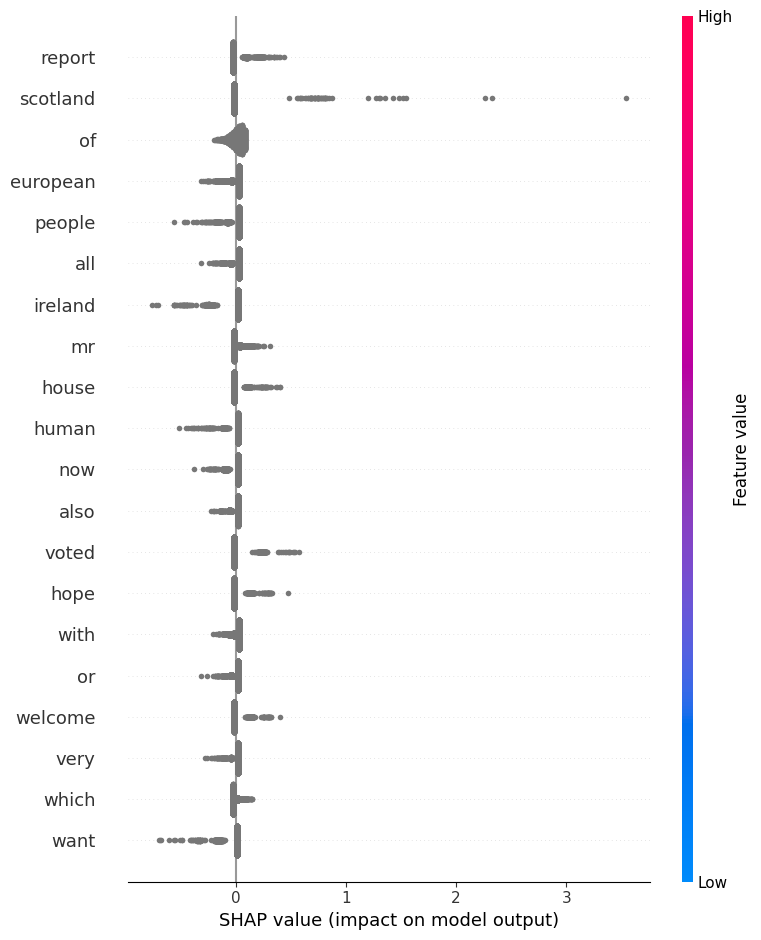

In [39]:
shap.summary_plot(shap_values_lr[2], X_test, feature_names=feature_names)